# Fitting is an Art!

Python macro for testing which fitting procedure is likely to give the "best" results.

In this case, we consider a **double exponential distribution**, where there are (naturally) high correlations, which have to be addressed/managed through the design of the fitting function.

### Authors:
- Troels Petersen ([email](mailto:petersen@nbi.dk))

### Last update:
- 28th of December 2024

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats

In [25]:
r = np.random
r.seed(42)
SavePlots = False

## CASE: Double exponential distribution

Here we are considering the fitting of exponential data, and how the writing of the fitting function is important.

* The "bad" fitting function:
    $f_{bad}(t)  = N_{1}\cdot\exp(-t/r_{1}) + N_{2}\cdot\exp(-t/r_{2})$ for $t$ in $[0,\infty]$

* The "good" fitting function:
    $f_{good}(t) = N \cdot\left(\frac{f}{r_{1}}\cdot \exp\left[-t/r_{1}\right] + \frac{(1-f)}{r_{2}}\cdot\exp\left[-t/r_{2}\right]\right)$ for $t$ in $[0,\infty]$

NOTE: The parameters $r_1$ and $r_2$ need to be positive, and $f$ in [0,1], in order for this to be a PDF.

In [26]:
Npoints = 2000
frac =  0.5               # Fraction that "belongs to" first exponential
tau1 = 10.0
tau2 =  2.0               # Note: The size of the lifetime ratio decides their correlation!
Nbins = 200
xmin = 0.0
xmax = 20.0
binwidth = (xmax - xmin) / Nbins
print(f"  The binwidth is {binwidth:.3f}")

  The binwidth is 0.100


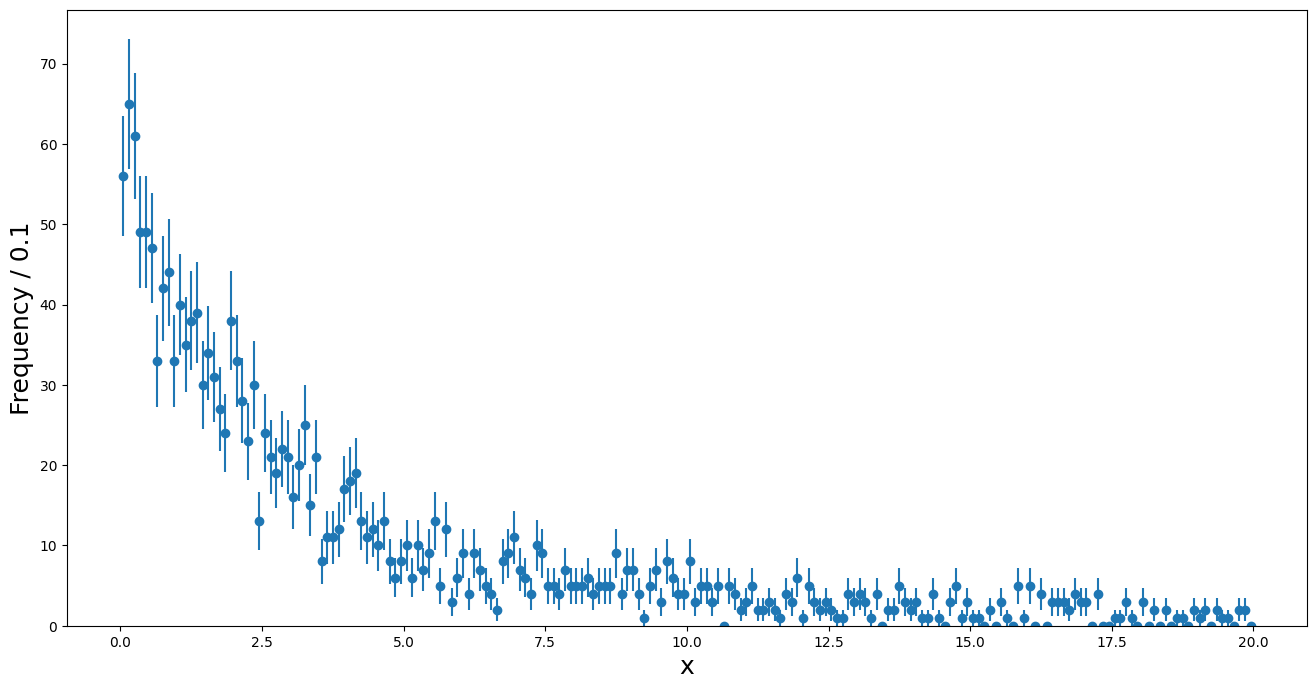

In [27]:
data = np.concatenate([r.exponential(scale=tau1, size=int(Npoints*frac)),
                       r.exponential(scale=tau2, size=int(Npoints*(1.0-frac)))])

counts, bin_edges = np.histogram(data, bins=Nbins, range=(xmin, xmax))
unc_count = np.sqrt(counts)
x = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2.

fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(x, counts, yerr=unc_count, marker = 'o', ls='')
ax.set_xlabel(f'x', fontsize=18)
ax.set_ylabel(f'Frequency / {binwidth:.1f}', fontsize=18)
ax.set_ylim(0.0);

### Let's try to fit the data with a bad model:

We include the bin width (here 0.1) in the fit to ensure that the normalisations are (or could be) right!

In [28]:
def func_2exp_bad(x, N1, tau1, N2, tau2):
    return binwidth * (N1*np.exp(-x/tau1) + N2*np.exp(-x/tau2))

def func_2exp_good(x, N, tau1, tau2):
    f = 0.5
    normalization = binwidth * N
    return normalization * (f/tau1*np.exp(-x/tau1) + (1.0-f)/tau2*np.exp(-x/tau2))

In [29]:
# NOTE: We actually start the fit with "perfect" initial values:
mask = counts>0
cfit = cost.LeastSquares(x[mask], counts[mask], unc_count[mask], func_2exp_good)
mfit = Minuit(cfit, N=1000.0, tau1=2.0, tau2=10.0)
mfit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 160.6 (χ²/ndof = 0.9)      │              Nfcn = 110              │
│ EDM = 0.000118 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │  1.81e3   │  0.05e3   │            │            │         │         │       │
│ 1 │ tau1 │   1.78    │   0.09    │            │            │         │         │       │
│ 2 │ tau2 │    8.6    │    0.9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬────────────────────────────┐
│      │        N     tau1     tau2 │
├──────┼────────────────────────────┤
│    N │ 2.55e+03    0.009     21.0 │
│ tau1 │    0.009  0.00819    0.000 │
│ tau2 │     21.0    0.000    0.729 │
└──────┴────────────────────────────┘

### Note on the covariance/correlation matrix:

You want your fit to have the **least** correlations between the fitting parameters.<br>
Try to check all the entries above, and see if you understand why the correlations are as they are.

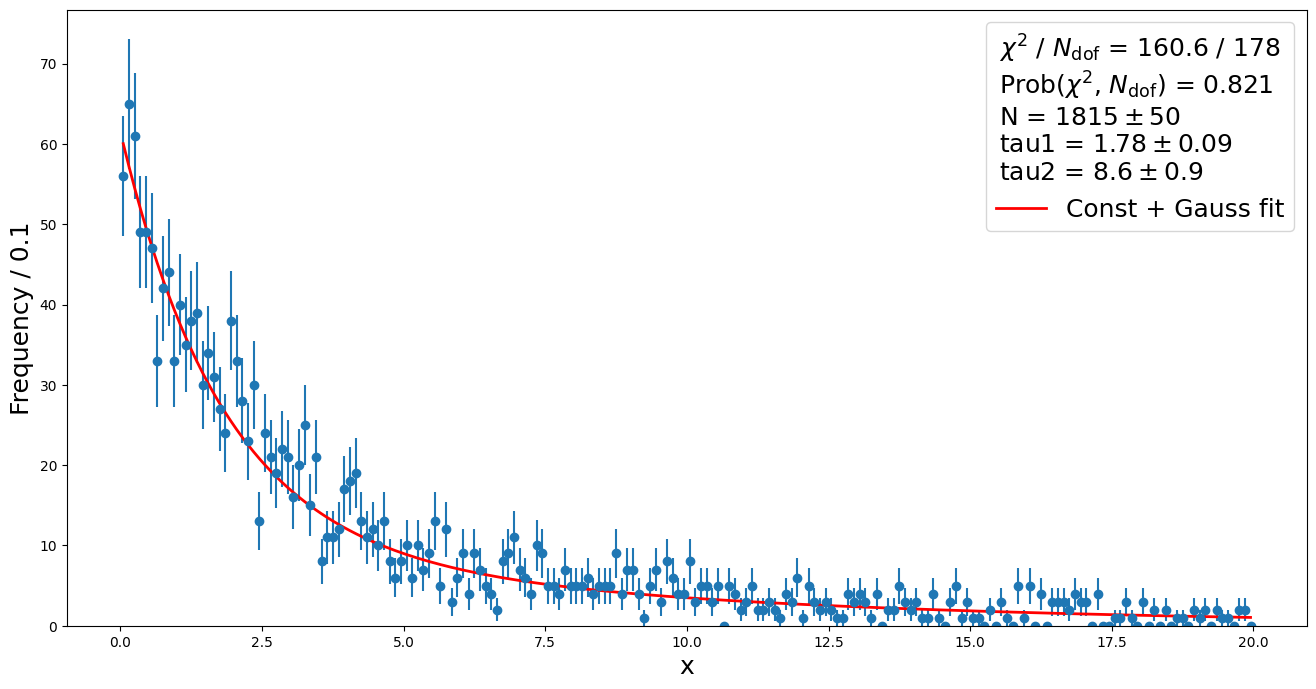

In [30]:
if (not mfit.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

ax.plot(x, func_2exp_good(x, *mfit.values[:]), 'r', linewidth=2.0, label='Const + Gauss fit')

# Adding fit results to plot:
chi2 = mfit.fval                     # ChiSquare value
Ndof = len(x[mask]) - mfit.nfit      # Number of (non-empty) bins
Prob = stats.chi2.sf(chi2, Ndof)     # ChiSquare probability given Ndof

fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {chi2:.1f} / {Ndof}", f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {Prob:.3f}",]
for p, v, e in zip(mfit.parameters, mfit.values[:], mfit.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f'{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$')

ax.legend(title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
fig

# Questions:
 1. Does the "bad" fit work well? Does it extract the parameters used to produce it?
    Can you see what is missing? There are in fact several things, but one is simple to remedy.
    Think and discuss...
   
---
_5-10 minutes later_...

---
For once it is not the initial values! The reason is that the "bad" fitting function has two flaws:

* It does not have a correct normalisation, thus making N1 and N2 correlated, as well as tau1 and tau2.
* It does not have a single overall normalisation, thus making N1 and N2 even more correlated.

This gives very high correlations between the parameters, as can be seen from the correlation matrix printed.

 2. Both of these problems can be mitigated by rewriting the fitting function to include
    the correct normalisation (i.e. dividing by the lifetime) and by putting only one
    overall normalisation and then dividing the two lifetimes with a fraction (i.e. use
    "frac" and "(1.0-frac)" as a parameter in front of each exponential term).
    Try this (define a "good" function), and see if your fit improves. The way to see
    this would in general be to try a lot of different data, but here we will simply see
    that the correlations are smaller (especially for the overall normalisation).
---
_10-20 minutes later_...

---  

If you didn't manage to get this fit going, I've included a "good" fitting function below! (but try yourself first!)

 3. The two lifetimes are naturally very correlated with each other (and the fraction),
    when they are very alike. The only thing one can do about this is to fix one parameter.
    Fixing a parameter is of course not desirable, but one can be forced to do it, if the fit does
    not converge otherwise. Note that since the correlation is very high, it is not a great
    loss of freedom in the fitting function. The correlation between tau1 and tau2 depends a lot
    on how similar they are.<br>
    Fix one parameter and see to what extend the fit becomes less correlated, the other parameters
    more precisely determined, and the quality of the fit improves.

 4. Finally, is it appropriate to fit the data with a ChiSquare? If not, then you should know what
    to do instead. A simpler alternative might be to simply change the binning.

---

NOTE: A very similar and common example is fitting a "Gaussian-like" peak, which happens to have
more than one width, for example if the data is obtained from two or more sources with
different resolutions. Here, one may choose to let the two (or more) Gaussians have
the same mean, but two different widths (the "good" and the "bad" measurements).
Typically, the parameter to fix (if any) is the fraction, but never fix a parameter
without first having tried to let it "float".
    
However, **no fit function is perfect** and the below fitting function is not an "absolute"
improvement. The improvement lies only in some parts of the parameter space, and it is hard
to know, when it has been improved.

### The GOOD fitting function:

In [31]:
def func_2exp_good(x, N, frac, tau1, tau2):
    return binwidth * N * (frac/tau1 * np.exp(-x/tau1) + (1.0-frac)/tau2 * np.exp(-x/tau2))

# Learning points:

This exercise in "fitting tricks" should teach you that:
1. __Good starting values is paramount!__ (Almost all fits fail with poor starting values).
2. The form of the fitting function is also important.<br>
   a. Ensure that the x-values do not represent some small range far from 0.<br>
   b. Ensure that you give the fitting function enough freedom to fit the data.
   c. Conversely, try to curb the number of parameters, if there are arguments for doing so (calibration peaks).
   d. Make sure that you've normalised your fitting PDFs, to avoid correlations between normalisation and parameters.
3. If a fit continues to fail, try simply to draw the function and starting values on top of the data. Often, they don't match well (general advice, not in this exercise).